Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 4

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization on Slack.

(If you haven't completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas_profiling
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('videogame_new.csv')
print(df.shape)
df.head()

(11465, 10)


,Unnamed: 0,Name,Global_Sales_x,Rank,Genre,Platform,Publisher,Developer,Critic_Score_y,Year
0,0,Wii Sports,82.53,1.0,Sports,Wii,Nintendo,Nintendo EAD,7.7,2006.0
1,1,Super Mario Bros.,40.24,2.0,Platform,NES,Nintendo,Nintendo EAD,10.0,1985.0
2,2,Super Mario Bros.,40.24,46906.0,Platform,VC,Nintendo,Nintendo EAD,9.0,2006.0
3,5,Mario Kart Wii,35.52,3.0,Racing,Wii,Nintendo,Nintendo EAD,8.2,2008.0
4,6,Wii Sports Resort,32.77,5.0,Sports,Wii,Nintendo,Nintendo EAD,8.0,2009.0


In [4]:
df = df.drop(columns='Unnamed: 0')
df.head()

,Name,Global_Sales_x,Rank,Genre,Platform,Publisher,Developer,Critic_Score_y,Year
0,Wii Sports,82.53,1.0,Sports,Wii,Nintendo,Nintendo EAD,7.7,2006.0
1,Super Mario Bros.,40.24,2.0,Platform,NES,Nintendo,Nintendo EAD,10.0,1985.0
2,Super Mario Bros.,40.24,46906.0,Platform,VC,Nintendo,Nintendo EAD,9.0,2006.0
3,Mario Kart Wii,35.52,3.0,Racing,Wii,Nintendo,Nintendo EAD,8.2,2008.0
4,Wii Sports Resort,32.77,5.0,Sports,Wii,Nintendo,Nintendo EAD,8.0,2009.0


In [5]:
features = ['Rank', 'Genre', 'Platform', 'Publisher', 'Developer', 'Critic_Score_y', 'Year']
df.profile_report()

In [6]:
Over_5m_sales = []
for x in df['Global_Sales_x']:
    if x > 5:
        Over_5m_sales.append(1)
    else:
        Over_5m_sales.append(0)

In [7]:
df['Over_5m_sales'] = Over_5m_sales
df.head()

,Name,Global_Sales_x,Rank,Genre,Platform,Publisher,Developer,Critic_Score_y,Year,Over_5m_sales
0,Wii Sports,82.53,1.0,Sports,Wii,Nintendo,Nintendo EAD,7.7,2006.0,1
1,Super Mario Bros.,40.24,2.0,Platform,NES,Nintendo,Nintendo EAD,10.0,1985.0,1
2,Super Mario Bros.,40.24,46906.0,Platform,VC,Nintendo,Nintendo EAD,9.0,2006.0,1
3,Mario Kart Wii,35.52,3.0,Racing,Wii,Nintendo,Nintendo EAD,8.2,2008.0,1
4,Wii Sports Resort,32.77,5.0,Sports,Wii,Nintendo,Nintendo EAD,8.0,2009.0,1


In [8]:
train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=200)
print(train.shape)
print(test.shape)

(9172, 10)
(2293, 10)


In [9]:
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=200)
print(train.shape)
print(val.shape)
print(test.shape)

(7337, 10)
(1835, 10)
(2293, 10)


In [10]:
target = 'Over_5m_sales'

X_train = train.drop(columns=target).drop(columns='Global_Sales_x')
y_train = train[target]
X_val = val.drop(columns=target).drop(columns='Global_Sales_x')
y_val = val[target]
X_test = test.drop(columns=target).drop(columns='Global_Sales_x')

In [11]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=250, n_jobs=-1, random_state=200)
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Name', 'Genre', 'Platform', 'Publisher',
                                      'Developer'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Name',
                                          'data_type': dtype('O'),
                                          'mapping': Legend of Kay                    1
The Sims 2                       2
BlazBlue: Calamity Trigger       3
Madden NFL 07                    4
Madden NFL 2004                  5
                              ... 
Battalion Wars 2              2439
Panzer Dragoon Sag...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                 

In [12]:
pipeline.score(X_val, y_val)

0.9651226158038148

In [17]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.818457	validation_1-auc:0.739934
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.847295	validation_1-auc:0.757791
[2]	validation_0-auc:0.847622	validation_1-auc:0.757733
[3]	validation_0-auc:0.870647	validation_1-auc:0.822735
[4]	validation_0-auc:0.874712	validation_1-auc:0.821687
[5]	validation_0-auc:0.874857	validation_1-auc:0.821629
[6]	validation_0-auc:0.874564	validation_1-auc:0.822473
[7]	validation_0-auc:0.882263	validation_1-auc:0.822124
[8]	validation_0-auc:0.882418	validation_1-auc:0.821716
[9]	validation_0-auc:0.882499	validation_1-auc:0.821668
[10]	validation_0-auc:0.896086	validation_1-auc:0.854884
[11]	validation_0-auc:0.897664	validation_1-auc:0.8529
[12]	validation_0-auc:0.897626	validation_1-auc:0.852871
[13]	validation_0-auc:0.897882	validation_1-auc:0.851872
[14]	validation_0-auc:0.897457	validation_1-auc:0.851551


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
import shap

row = X_test.iloc[[16]]
explainer = shap.TreeExplainer(model)
row_process = processor.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

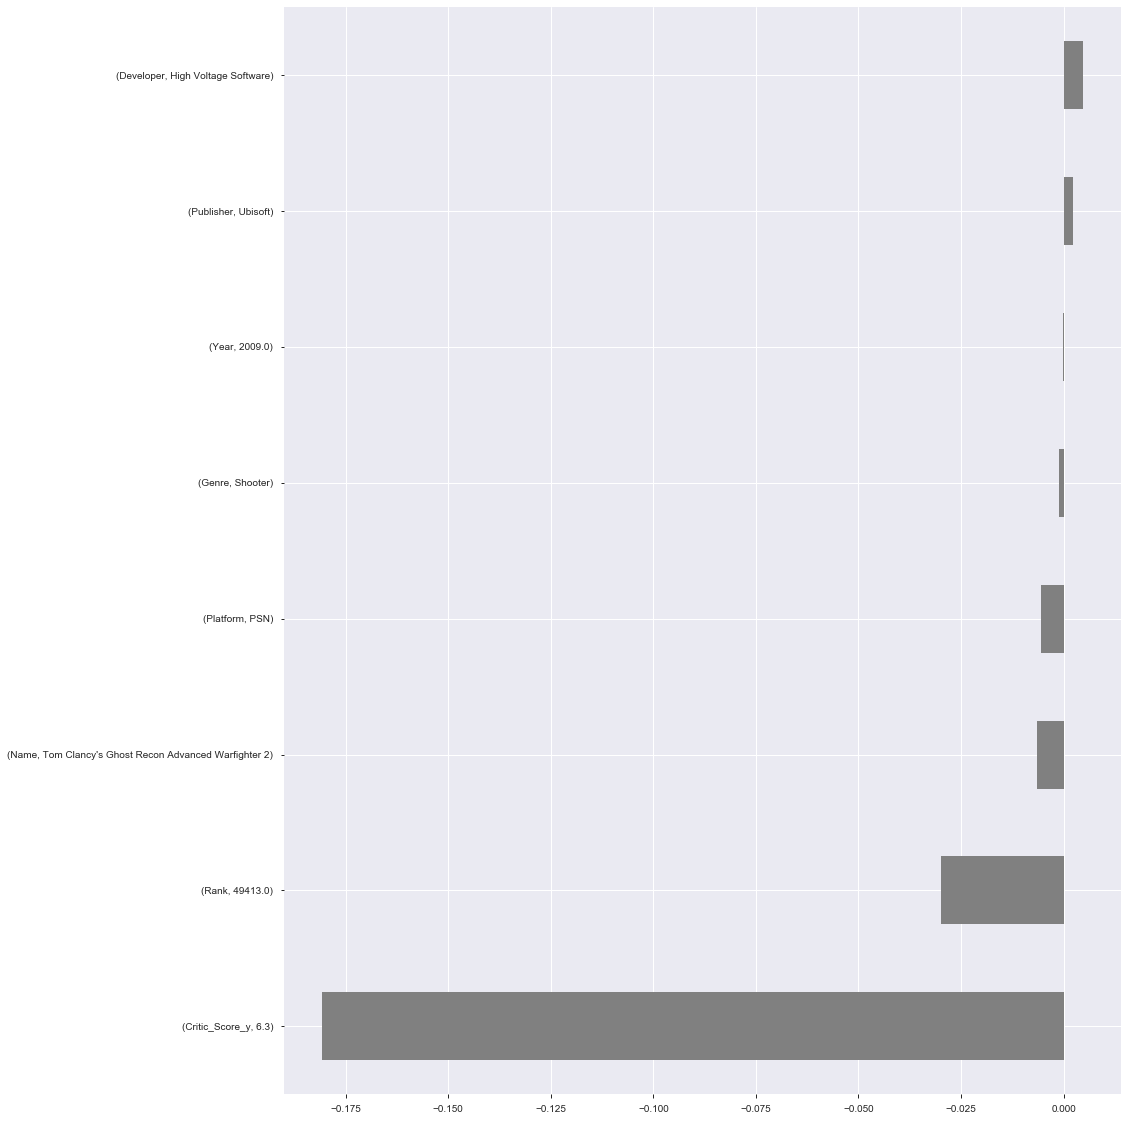

In [19]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names,feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));

In [20]:
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1
    
    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)
    
    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba
    
    # Show prediction & probability
    print(f'The model predicts this loan is {pred}, with {pred_proba:.0f}% probability.')
    

    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)
    
    # Get top 3 "pros & cons"
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index
   
    # Show top 3 reasons for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')
    
    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0] 
    print(f'- {feature_name} is {feature_value}.')
    
    
    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row
    )

In [22]:
explain(16)

The model predicts this loan is 0, with 95% probability.


Top 3 reasons for prediction:
1. Critic_Score_y is 6.3.
2. Rank is 49413.0.
3. Name is Tom Clancy's Ghost Recon Advanced Warfighter 2.


Top counter-argument against prediction:
- Developer is High Voltage Software.


In [27]:
explain(36)

The model predicts this loan is 1, with 34% probability.


Top 3 reasons for prediction:
1. Genre is Shooter.
2. Publisher is Microsoft Game Studios.
3. Year is 2007.0.


Top counter-argument against prediction:
- Rank is 44.0.
